# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    # define set of imaage and tensor transformations
    transform = transforms.Compose([transforms.Resize(size=(image_size,image_size)), # resize to image
                                    transforms.ToTensor()]) # transform numpy array to tensor
    
    # prepare image dataset using ImageFolder function and above specified set of image transformations
    train_image_dataset = datasets.ImageFolder(data_dir, transform)
    
    # define number of sub-processes to load the data
    num_workers = 0    # default = 0: data will be loaded in the main process
    
    # prepare data loader
    train_data_loader = torch.utils.data.DataLoader(dataset=train_image_dataset, 
                                                    batch_size=batch_size, 
                                                    shuffle=True,
                                                    num_workers=num_workers)
    
    # return data loader
    return train_data_loader

## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

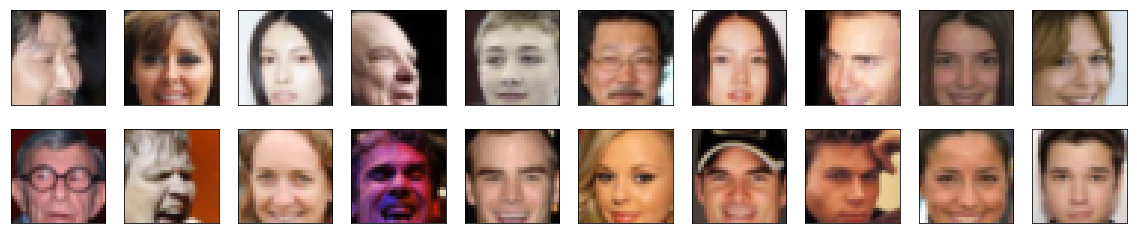

In [6]:
# helper display function
def imshow(img):
    # convert image tensor to numpy array
    npimg = img.numpy()
    # show transposed image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = (x * (max - min)) + min
    return x

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9608)
Max:  tensor(0.9608)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
# helper conv() function to set up a convolutional 2D layer with an optional attached batch norm layer
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a 2D convolutional layer (for downscaling width and height of the input tensor) with an 
       attached optional batch normalization layer.
       
       Arguments:
       
       in_channels:  input channels resp. depth of input tensor
       out_channels: output channels resp. depth of output tensor
       kernel_size:  kernal size of transposed convolutional filter (default: 4)
       stride:       stride to shift the filter kernel along tensor width and height (default: 2)
       padding:      number of rows / colums padded with zeros on the outer rims of the tensor (default: 1)
       batch_norm:   flag to switch batch normalization on (batch_norm = True) or off (batch_norm = False)
       
       Remark:       For downscaling tensor width x height of by a factor of 2 use convolutional layers with 
                     filter kernel size = 4, stride = 2 and padding = 1       
    """
    
    # initialize list of layers
    layers = []
    
    # specify 2D convolutional layer
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append 2D convolutional layer
    layers.append(conv_layer)
    
    if batch_norm:
        # append 2D batch normalization layer
        layers.append(nn.BatchNorm2d(out_channels))
    
    # return sequential stack of layers
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        # complete init function
        self.conv_dim = conv_dim # default: conv_dim = 32
        
        # Use default convolutional filter settings for downscaling by factor of 2:
        # kernel_size = 4
        # stride = 2
        # padding = 1
        
        # 1st convolutional layer (no batch norm) => in: 3x32x32 tensor | out: 128x16x16 tensor
        self.conv1 = conv(in_channels=3, out_channels=conv_dim, batch_norm=False)
        
        # 2nd convolutional layer (with batch norm) => in: 128x16x16 tensor | out: 256x8x8 tensor
        self.conv2 = conv(in_channels=conv_dim, out_channels=2*conv_dim, batch_norm=True)
        
        # 3rd convolutional layer (with batch norm) => in: 256x8x8 tensor | out: 512x4x4 tensor
        self.conv3 = conv(in_channels=2*conv_dim, out_channels=4*conv_dim, batch_norm=True)
        
        # Dropout layer after fully connected input layer as regularization means 
        self.dropout = nn.Dropout(p=0.2)
        
        # Final fully-connected layer => in: 512x4x4 (flattened) tensor | out: 1x1 tensor
        self.fc = nn.Linear(in_features=4*4*4*conv_dim, out_features=1)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        # 1st convolutional layer (input layer) with leaky ReLu activation (no pooling layer)
        # => in: 3x32x32 tensor | out: 128x16x16 tensor
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
                
        # 2nd convolutional layer (input layer) with leaky ReLu activation (no pooling layer)
        # => in: 128x16x16 tensor | out: 256x8x8 tensor
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)        
        
        # 3rd convolutional layer (input layer) with leaky ReLu activation (no pooling layer)
        # => in: 256x8x8 tensor | out: 512x4x4 tensor
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        
        # Flatten input vector to final fully-connected layer
        # => in: 512x4x4 = (4*128)x4x4 tensor | out: 1x8192 tensor
        x = x.view(-1, 4*4*4*self.conv_dim)
        
        # Regularization by dropout layer after first fully-connected input layer
        x = self.dropout(x)
        
        # Final fully-connected layer
        # 
        # Stop here if BCEWithLogitsLoss() is chosen as optimization criterion
        # Remark: BCEWithLogitsLoss() combines a Sigmoid layer and the BCELoss in one single class. 
        # This version is more numerically stable than using a plain Sigmoid followed by a BCELoss 
        # as, by combining the operations into one layer, we take advantage of the log-sum-exp trick 
        # for numerical stability.
        # => in: 1x8192 tensor | out: 1x1 tensor
        x = self.fc(x)
        
        # Add an additional sigmoid function in case MSELoss() is selected as optimization criterion
        x = F.sigmoid(x) # Commend this out if BCEWithLogitsLoss() criterion is used!!!
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


/home/andreas/anaconda3/envs/deep-learning/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv() function to set up a 2D deconvolutional layer with an attached optional batch norm layer
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a 2D transposed-convolutional layer (for upscaling width and height of the input tensor) 
       with an attached optional batch normalization layer.
       
       Arguments:
       
       in_channels:  input channels resp. depth of input tensor
       out_channels: output channels resp. depth of output tensor
       kernel_size:  kernal size of transposed convolutional filter (default: 4)
       stride:       stride to shift the filter kernel along tensor width and height (default: 2)
       padding:      number of rows / colums padded with zeros on the outer rims of the tensor (default: 1)
       batch_norm:   flag to switch batch normalization on (batch_norm = True) or off (batch_norm = False)
       
       Remark:       For upscaling tensor width x height of by a factor of 2 use deconvolutional layers with 
                     filter kernel size = 4, stride = 2 and padding = 1       
    """
    
    # initialize list of layers
    layers = []
    
    # specify 2D transposed convolutional layer
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    
    # append 2D transposed convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append 2D batch normalization layer
        layers.append(nn.BatchNorm2d(out_channels))
    
    # return sequential stack of layers
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()
        
        # complete init function
        self.conv_dim = conv_dim # default: conv_dim = 32
        
        # Final fully-connected layer => in: 1xz_size tensor | out: 1x8192 = 1x(4*4*512) (flattened) tensor
        self.fc = nn.Linear(in_features=z_size, out_features=4*4*4*conv_dim)
        
        # Dropout layer after fully connected input layer as regularization means 
        self.dropout = nn.Dropout(p=0.2)
        
        # Use default convolutional filter settings for downscaling by factor of 2:
        # kernel_size = 4
        # stride = 2
        # padding = 1
        
        # 1st transposed convolutional 2D layer (with batch norm) => in: 512x4x4 tensor | out: 256x8x8 tensor
        self.t_conv1 = deconv(in_channels=4*conv_dim, out_channels=2*conv_dim, batch_norm=True)
        
        # 2nd transposed convolutional 2D layer (with batch norm) => in: 256x8x8 tensor | out: 128x16x16 tensor
        self.t_conv2 = deconv(in_channels=2*conv_dim, out_channels=conv_dim, batch_norm=True)
        
        # 3rd transposed convolutional 2D layer (no batch norm) => in: 128x16x16 tensor | out: 3x32x32 tensor
        self.t_conv3 = deconv(in_channels=conv_dim, out_channels=3, batch_norm=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        # Feed input of size z_size x 1 through 1st fully-connected layer
        # => in: 1xz_size tensor | out: 1x8192 tensor
        x = self.fc(x)
        
        # Regularization by dropout layer after first fully-connected input layer
        x = self.dropout(x)
        
        # Reshape the flattened input tensor to a block of stacked feature maps
        # => in: 1x8192 tensor | out: 512x4x4 tensor
        x = x.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # 1st transposed convolutional (deconvolutional) 2D layer with leaky ReLu activation
        x = F.leaky_relu(self.t_conv1(x), negative_slope=0.2)
        
        # 2nd transposed convolutional (deconvolutional) 2D layer with leaky ReLu activation
        x = F.leaky_relu(self.t_conv2(x), negative_slope=0.2)
        
        # 3rd and final transposed convolutional (deconvolutional) 2D layer with tanh activation
        x = torch.tanh(self.t_conv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(model):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param model: A module or layer in a neural netowork model 
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = model.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Conv2d or ConvTranspose2d in a model
    # - model.weight.data is sampled from a normal distribution with mean = 0 and std_dev = 0.02
    # remark: bias is switched off here in the convolutional layers
    if classname.find('Conv') != -1:
        print('Updating weights for | ' + str(classname))
        #torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
        model.weight.data.normal_(0.0, 0.02)
    
    # for every Linear layer in a model
    # - model.weight.data is sampled from a normal distribution with mean = 0 and std_dev = 0.02
    # - model.bias.data is set to zero
    if classname.find('Linear') != -1:
        print('Updating weights for | ' + str(classname))
        #torch.nn.init.normal_(model.weight.data, 0.0, 0.02)
        model.weight.data.normal_(0.0, 0.02)
        model.bias.data.fill_(0.0)

def weights_init_xavier(model):
    """
    Applies initial weights to certain layers in a model.
    The weights are filled in using a uniform distribution according to the method described in 
    "Understanding the difficulty of training deep feedforward neural networks" by Glorot, X. 
    and Bengio, Y. (2010). The resulting tensor will have values sampled from a distribution 
    U(−a,a) where a = gain x sqrt(6 / (fan_in+fan_out). Also known as Glorot initialization.
    :param model: A module or layer in a neural netowork model  
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = model.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    # for every Conv2d or ConvTranspose2d in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # remark: bias is switched off here in the convolutional layers
    if classname.find('Conv') != -1:
        print('Updating weights for | ' + str(classname))
        torch.nn.init.xavier_uniform(model.weight.data)
    
    # for every Linear layer in a model
    # - model.weight.data are filled in using Xavier Glorot initialization method
    # - model.bias.data is set to zero
    if classname.find('Linear') != -1:
        print('Updating weights for | ' + str(classname))
        torch.nn.init.xavier_uniform(model.weight.data)
        model.bias.data.fill_(0.0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    # D.apply(weights_init_normal) # normal distribution
    # G.apply(weights_init_normal) # normal distribution
    D.apply(weights_init_xavier) # Xavier/Glorot method
    G.apply(weights_init_xavier) # Xavier/Glorot method

    print(D)
    print()
    print(G)
    
    return D, G

#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Updating weights for | Conv2d
Updating weights for | Conv2d
Updating weights for | Conv2d
Updating weights for | Linear
Updating weights for | Linear
Updating weights for | ConvTranspose2d
Updating weights for | ConvTranspose2d
Updating weights for | ConvTranspose2d
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (dropout): Dropo

/home/andreas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/home/andreas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    # get batch size
    batch_size = D_out.size(0)
    
    # set target labels for detecting real images correctly => set all target labels to one
    labels = torch.ones(batch_size) # real labels = 1
    
    # move target labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    
    ## Choice of optimization criterion for backpropagation:
    # 
    # Option 1: BCEWithLogitsLoss() resp. Binary Cross Entropy With Logits Loss
    # Remark: BCEWithLogitsLoss() combines a sigmoid function with binary cross entropy loss
    # criterion = nn.BCEWithLogitsLoss()
    # 
    # Option 2: MSELoss() resp. Mean Squared Error Loss
    # Remark: This requires an additional sigmoid function at the discriminator forward
    criterion = nn.MSELoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    # return loss on discriminating real from fake images correctly
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    # get batch size
    batch_size = D_out.size(0)
    
    # set target labels for detecting fake images correctly => set target labels all to zero
    labels = torch.zeros(batch_size) # fake labels = 0
    
    # move target labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    
    ## Choice of optimization criterion for backpropagation:
    # 
    # Option 1: BCEWithLogitsLoss() resp. Binary Cross Entropy With Logits Loss
    # Remark: BCEWithLogitsLoss() combines a sigmoid function with binary cross entropy loss
    # criterion = nn.BCEWithLogitsLoss()
    # 
    # Option 2: MSELoss() resp. Mean Squared Error Loss
    # Remark: This requires an additional sigmoid function at the discriminator forward
    criterion = nn.MSELoss()
    
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    # return loss on discriminating fake from real images correctly
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# Select optimizer
optimizer = 'Adam'
# optimizer = 'SGD'

# Create optimizers for the discriminator and generator
if optimizer == 'Adam':
    # optimization parameters for Adam optimizer
    lr = 1e-4            # learning rate (default: 1e-3)
    beta1 = 0.5          # lower beta coefficient for computing running averages of gradient and its square (default: 0.9
    beta2 = 0.999        # upper beta coefficient for computing running averages of gradient and its square (default: 0.999)
    eps = 1e-08          # term added to the denominator to improve numerical stability (default: 1e-8)
    weight_decay = 1e-07 # weight decay resp. L2 penalty (default: 0)

    # Create optimizers for the discriminator D and generator G using Adam optimizer
    # torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2], eps, weight_decay)
    g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2], eps, weight_decay)
    
elif optimizer == 'SGD':
    # optimization parameters for stochastic gradient descent (SGD) optimizer
    lr = 1e-4            # learning rate
    momentum = 0.4       # momentum factor (default: 0.0)
    dampening = 0.1      # dampening for momentum (default: 0.0)
    weight_decay = 1e-7  # weight decay resp. L2 penalty (default: 0.0)
    
    # Create optimizers for the discriminator D and generator G using SGD optimizer
    # torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)
    d_optimizer = optim.SGD(D.parameters(), lr, momentum, dampening, weight_decay)
    g_optimizer = optim.SGD(G.parameters(), lr, momentum, dampening, weight_decay)

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
    
    # set discriminator and generator models to training mode
    D.train()
    G.train()
    
    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed random data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            # get batch size
            batch_size = real_images.size(0)
            
            # important rescaling step: (0...1) => (-1...1)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # ===============================================
            #              TRAIN THE DISCRIMINATOR
            # ===============================================
            
            # Set discriminator gradients to zero for the next training cycle
            d_optimizer.zero_grad()
            
            ## 1. Train the discriminator on real images ##
            
            # move real images to GPU if available
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # forward pass of real images through the discriminator
            D_real = D(real_images)
            
            # calculate the discriminator losses on real images
            # (Ideally, D_real should be as close to 1 as possible)
            d_real_loss = real_loss(D_real)
            
            ## 2. Train the discriminator on fake images ##
            
            # Compute the discriminator losses on fake images obtained from the generator
            
            # create random latent vector to generate fake images scaled to a pixel value range of (-1...1)
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # convert latent vector to tensor
            z = torch.from_numpy(z).float()
            
            # move latent tensor to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            
            # generate fake images with the generator in forward pass
            fake_images = G(z)
            
            # forward pass of fake images through the discriminator
            D_fake = D(fake_images)
            
            # compute the discriminator losses on fake images
            # (Ideally, D_fake should be as close to 0 as possible if the discriminator works perfectly, 
            # D_fake would be close to 1 if the generator does a perfect job in tricking the discriminator.)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss on real and fake images and perform backprop
            d_loss = d_real_loss + d_fake_loss
            
            # calculate gradients for discriminator parameters
            d_loss.backward()
            
            # perform backpropagation step on the discriminator
            d_optimizer.step()
        
            # ============================================
            #               TRAIN THE GENERATOR
            # ============================================
            
            # set generator gradients to zero for the next training cycle
            g_optimizer.zero_grad()
            
            ## 3. Train the generator with an adversarial loss resp. with fake images and flipped labels ##
            
            # create random latent vector to generate fake images scaled to a pixel value range of (-1...1)
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            
            # convert latent vector to tensor
            z = torch.from_numpy(z).float()
            
            # move latent tensor to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            
            # generate fake images with the generator in forward pass
            fake_images = G(z)
            
            # forward pass of fake images through the discriminator
            D_fake = D(fake_images)
            
            # Compute the discriminator losses on fake images using flipped labels!
            # flip labels using real loss function to trick the discriminator with the generated images:
            # Generator loss becomes small (large) if discriminator outputs D_fake = 1 (0) for it believes
            # the fake images are real (does not believe the fake images are real).
            g_loss = real_loss(D_fake) 
            
            # calculated gradients for the generator parameters
            g_loss.backward()
            
            # perform backpropagation step
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# Number of batches per epoch
print('Number of batches per epoch: ', len(iter(celeba_train_loader)))
# Get last batch index
# last_batch_idx = [batch_idx for batch_idx, (_, _) in enumerate(celeba_train_loader)][-1]
# print(last_batch_idx)

Number of batches per epoch:  1406


In [22]:
# set number of epochs 
n_epochs = 200

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs, print_every=len(iter(celeba_train_loader)))

Epoch [    1/  200] | d_loss: 0.7015 | g_loss: 0.3058
Epoch [    2/  200] | d_loss: 0.1934 | g_loss: 0.3703
Epoch [    3/  200] | d_loss: 0.2988 | g_loss: 0.5332
Epoch [    4/  200] | d_loss: 0.3176 | g_loss: 0.5988
Epoch [    5/  200] | d_loss: 0.3366 | g_loss: 0.4229
Epoch [    6/  200] | d_loss: 0.3918 | g_loss: 0.4885
Epoch [    7/  200] | d_loss: 0.3250 | g_loss: 0.4935
Epoch [    8/  200] | d_loss: 0.2738 | g_loss: 0.5727
Epoch [    9/  200] | d_loss: 0.1904 | g_loss: 0.5660
Epoch [   10/  200] | d_loss: 0.2993 | g_loss: 0.6506
Epoch [   11/  200] | d_loss: 0.1239 | g_loss: 0.6633
Epoch [   12/  200] | d_loss: 0.1765 | g_loss: 0.5174
Epoch [   13/  200] | d_loss: 0.1676 | g_loss: 0.7972
Epoch [   14/  200] | d_loss: 0.1992 | g_loss: 0.5321
Epoch [   15/  200] | d_loss: 0.2475 | g_loss: 0.4008
Epoch [   16/  200] | d_loss: 0.3669 | g_loss: 0.8539
Epoch [   17/  200] | d_loss: 0.1104 | g_loss: 0.6444
Epoch [   18/  200] | d_loss: 0.2052 | g_loss: 0.7505
Epoch [   19/  200] | d_loss

Epoch [  153/  200] | d_loss: 0.0001 | g_loss: 0.9067
Epoch [  154/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  155/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  156/  200] | d_loss: 0.0835 | g_loss: 0.9073
Epoch [  157/  200] | d_loss: 0.0056 | g_loss: 0.9634
Epoch [  158/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  159/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  160/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  161/  200] | d_loss: 1.0000 | g_loss: 0.0000
Epoch [  162/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  163/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  164/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  165/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  166/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  167/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  168/  200] | d_loss: 0.0000 | g_loss: 1.0000
Epoch [  169/  200] | d_loss: 0.1788 | g_loss: 0.4451
Epoch [  170/  200] | d_loss: 0.0092 | g_loss: 0.9727
Epoch [  171/  200] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

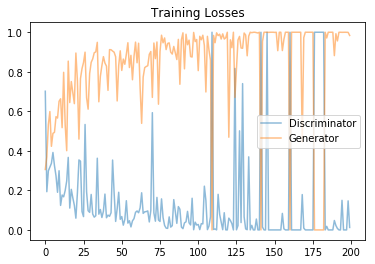

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [24]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [25]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

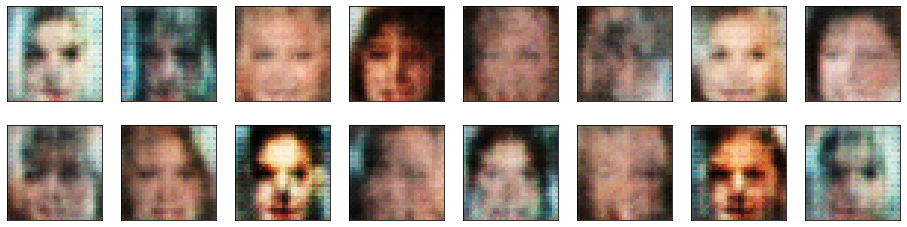

In [26]:
_ = view_samples(0, samples)

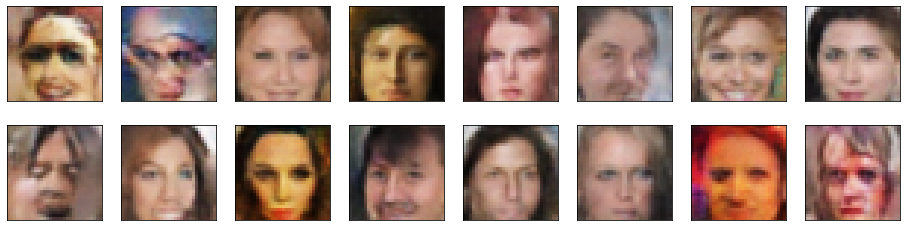

In [27]:
if n_epochs > 25:
    _ = view_samples(25, samples)

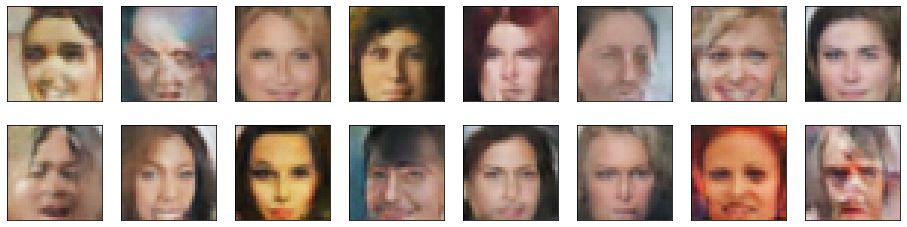

In [28]:
if n_epochs > 50:
    _ = view_samples(50, samples)

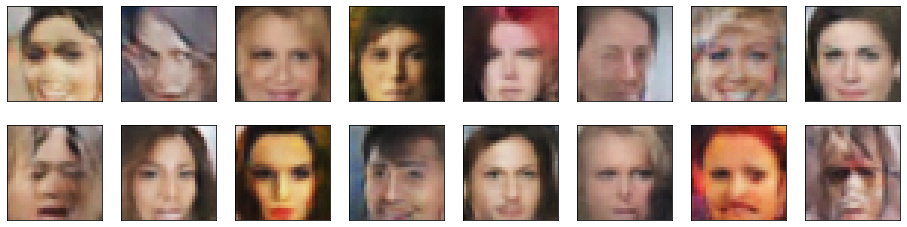

In [29]:
if n_epochs > 75:
    _ = view_samples(75, samples)

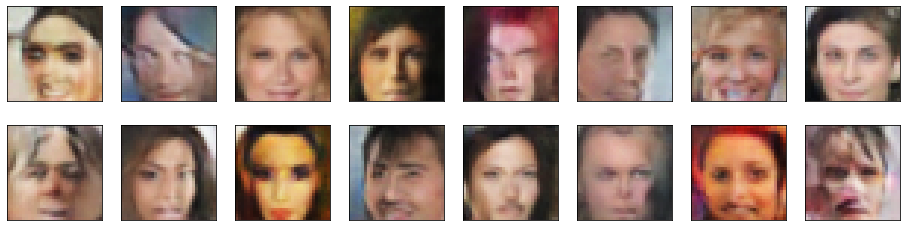

In [30]:
if n_epochs > 100:
    _ = view_samples(100, samples)

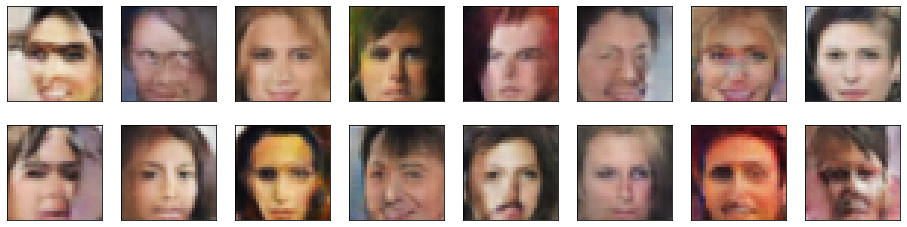

In [31]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)  

#### Results - generated images:   
- As expected the sample images look very noise at the beginning ... as they are initialized
- Then already after a few iterations the face contours become step by step more clear
- But even with the best setting after 200 epochs faces are still very pixelated. There are also distorted faces among the samples.
- So this problem tends to require rather long training periods, but there also seems to be a limitation due to the model itself or the way we calculate the loss because a variation of the training parameters has an effect on the loss characteristics and how quick faces are recognizable but not that much on the possible final results. The best possible quality seems to saturate here (or maybe I haven't found the best setting yet).

#### Weight initialization:  
- Initializing weights from a normal distribution or using Xavier/Glorot only effects the starting point, but has no noticable effect on the longterm outcome of the training process
- Xavier/Glorot is chosen as it results in a smaller discriminator and genertor loss at the beginning

#### Optimization criterion:   
- Training with BCEWithLogitsLoss() results in larger discriminator and especially generator losses with stronger oscillations (when plotting in shorter print intervals, e. g. every 50 batches) where the generator losses also tend to increase over the number of epochs
- Instead training with MSELoss() results in smaller discriminator and generator losses with less oscillations (when plotting in shorter print intervals, e. g. every 50 batches) and a much smaller increase of the generator losses over number of epochs. With MSELoss() criterion discriminator and generator loss tend to converge towards 0 resp. 1 for increasing numbers of training cycles (epochs).

#### Optimization algorithm:   
- MSELoss() combined with SGD optimizer results in small losses with very low oscillation. However, the generated images look not very good aver 50 epochs e. g. compared to MSELoss() combined with Adams optimizer
- Adams seems to work better with this problem for it generates more real looking faces in a shorter number of epochs though it tends to cause higher generator losses and stronger oscillations in the loss characteristics over the number of epochs or batches
- In general Adams seem to work best combined with MSELoss(). So this is the choice. It seems that discriminator loss and generator loss converge to 0 resp. 1 with Adams in combination with MSELoss() for increasing numbers of epochs (approx. n_epochs > 100). However, it seems that the quality of the generated test images also saturates and does not get so much better with longer training any more.

#### Hyperparameter tuning:  
- Further hyperparameter tuning may lead to some further improvements, but the maximum doable effect might be limited. Some suggestions: further reduction of learning rate, maybe introduction of some learning rate decay and/or further increase of L2 penalty using weight decay.

#### CNN model:   
- The model selected here seems to work in principle on the reduced 32 x 32 CelebA data set provided for this exercise, but there is still room for improvement, when looking at the sample images.
- We could add the one or another stack of convolutional layers to the existing blocks keeping the same size. This way, we can increase the depth of the CNN and its theoretical potential to learn more meaningful features, but I haven't tried it yet. Of course this comes again with higher computational costs.
- Another option would be to go for a higher image resolution (e. g. 64 x 64 or 128 x 128) in general. Then we definitely need a larger and maybe deeper CNN, which might yield better results.

#### Input - original images:   
- As we are working with a reduced amount of celebrety images a good option to improve the results would be to increase the size and the variety of the training data set. This can be done by including the rest of the publicly available celebrety images. This should also introduce a larger variety of people's faces (e. g. by having more colored people for instance or old/young resp. female/male samples).
- The reduced resolution of target images of 32 x 32 pixesl seems to be rather low, too, as they are already somewhat pixelated. As mentioned above, I would rather choose a higher resolution of 64 x 64 or 128 x 128 pixels in the next step, which comes with a higher computational cost for training of course.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.